In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
colours = sns.color_palette("husl", 8)
cs = [colours[i] for i in range(len(colours))]
sns.set_palette(sns.color_palette(colours))
register_matplotlib_converters()

# Load Data

In [2]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "14", "35", "37", "69", "328", "6"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")
b_6 = pd.read_csv("data/6 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69
data["6"] = b_6

# need to swap the inbound and outbound labels for data before 12/05/20 because 
# I noted them down wrong from the data collection stage
def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    
    df.loc[df['direction'] == 'out', 'direction'] = 'inbound'
    df.loc[df['direction'] == 'in', 'direction'] = 'outbound'
    df = df[["bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    
    df.rename(columns={'expected_arrival':'time_of_arrival'}, inplace=True)
    df = df.sort_values(by='time_of_arrival', ignore_index=True)
    return df

In [3]:
def add_extra_data(route):
    if route != "6":
        more = pd.read_csv("data/" + route + " 22-04-20.csv")
        more.loc[more['arrived'] == 1, 'arrived'] = True
        more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
        data[route] = data[route].append(more, ignore_index = True)
    
    more = pd.read_csv("data/" + route + " 12-05-20.csv")
    more.loc[more['arrived'] == 1, 'arrived'] = True
    more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    data[route] = data[route].append(more, ignore_index = True)

In [4]:
for route in routes:
    add_extra_data(route)

In [5]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (56938, 6)
BUS ROUTE:  9
Shape:  (49935, 6)
BUS ROUTE:  52
Shape:  (92505, 6)
BUS ROUTE:  267
Shape:  (50939, 6)
BUS ROUTE:  277
Shape:  (71103, 6)
BUS ROUTE:  7
Shape:  (43271, 6)
BUS ROUTE:  14
Shape:  (80413, 6)
BUS ROUTE:  35
Shape:  (50120, 6)
BUS ROUTE:  37
Shape:  (78808, 6)
BUS ROUTE:  69
Shape:  (53844, 6)
BUS ROUTE:  328
Shape:  (41514, 6)
BUS ROUTE:  6
Shape:  (84330, 6)


In [6]:
import json

stops_in_sequence_inbound = {}
stops_in_sequence_outbound = {}

for r in routes:
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/inbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_inbound[r] = stops
        
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/outbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_outbound[r] = stops
        
print(stops_in_sequence_inbound.get("52"))

Making API call to get all stops on route  452
Making API call to get all stops on route  452
Making API call to get all stops on route  9
Making API call to get all stops on route  9
Making API call to get all stops on route  52
Making API call to get all stops on route  52
Making API call to get all stops on route  267
Making API call to get all stops on route  267
Making API call to get all stops on route  277
Making API call to get all stops on route  277
Making API call to get all stops on route  7
Making API call to get all stops on route  7
Making API call to get all stops on route  14
Making API call to get all stops on route  14
Making API call to get all stops on route  35
Making API call to get all stops on route  35
Making API call to get all stops on route  37
Making API call to get all stops on route  37
Making API call to get all stops on route  69
Making API call to get all stops on route  69
Making API call to get all stops on route  328
Making API call to get all stop

## Helper Functions

In [7]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time

In [8]:
def pre_lockdown(given_time):
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    
    # lockdown = March 24th 2020
    if month > 3:
        return False
    elif month == 3:
        if day >= 24:
            return False
    
    return True

## Data Preprocessing

Pick 2 stops on a route. Calculate all the journey times between them. Make a dataset with attributes time of day (split into hour slots), journey time, day of week, pre lockdown.

Choose "North End Road" to "Phillimore Gardens" on route 9 inbound

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

b_9 = data.get("9")
north_end_rd = b_9.loc[(b_9['bus_stop_name'] == 'North End Road') & (b_9['direction'] == 'inbound')]
phillimore_g = b_9.loc[(b_9['bus_stop_name'] == 'Phillimore Gardens') & (b_9['direction'] == 'inbound')]
[_, north_end_rd_id, _, _, _] = north_end_rd.iloc[0]['vehicle_id'].split('_')
[_, phillimore_id, _, _, _] = phillimore_g.iloc[0]['vehicle_id'].split('_')

print(north_end_rd.shape)
print(phillimore_g.shape)

north_end_rd.head()

(882, 5)
(902, 5)


,bus_stop_name,time_of_arrival,vehicle_id,time_of_req,direction
0,North End Road,2020-03-10 10:00:50,15447_490010357F_2020-03-10_out_0,2020-03-10 10:01:02,inbound
115,North End Road,2020-03-10 10:25:02,15460_490010357F_2020-03-10_out_0,2020-03-10 10:24:39,inbound
146,North End Road,2020-03-10 10:29:40,14575_490010357F_2020-03-10_out_0,2020-03-10 10:29:38,inbound
193,North End Road,2020-03-10 10:38:36,14537_490010357F_2020-03-10_out_0,2020-03-10 10:38:53,inbound
245,North End Road,2020-03-10 10:46:27,14558_490010357F_2020-03-10_out_0,2020-03-10 10:46:27,inbound


In [10]:
start = time.time()
attrs = []

for i, journey in phillimore_g.iterrows():
    arr_dt = convert_time_to_datetime(journey['time_of_arrival'])

    [bus_id, phillimore_id, date, direction, _] = journey['vehicle_id'].split('_')
    to_match_id = bus_id + '_' + north_end_rd_id + '_' + date + '_' + direction + '_'

    for j, match in north_end_rd.iterrows():
        if match['vehicle_id'].startswith(to_match_id):
            leave_dt = convert_time_to_datetime(match['time_of_arrival'])
            journey_time = arr_dt - leave_dt

            if (journey_time > dt.timedelta(minutes = 0)) & (journey_time < dt.timedelta(minutes = 30)):
                item = []
                item.append(journey_time)
                
                seconds = journey_time.total_seconds()
                item.append(seconds)
                
                d = dt.datetime.strptime(match['time_of_arrival'][:10], '%Y-%m-%d')
                d = calendar.day_name[d.weekday()]
                item.append(d)
                
                t = int(journey['time_of_arrival'][11:13])
                item.append(t)
                
                c = pre_lockdown(journey['time_of_arrival'])
                item.append(c)
                
                attrs.append(item)
                break

print("Getting journey times took {}".format(time.time() - start))

Getting journey times took 121.04208707809448


In [11]:
df = pd.DataFrame(attrs, columns = ['Journey Time', 'Journey Time (s)', 'Day of Week', 'Time of Day', 'Pre Lockdown'])
df.head()

,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown
0,00:09:32,572.0,Tuesday,10,True
1,00:10:43,643.0,Tuesday,10,True
2,00:09:37,577.0,Tuesday,10,True
3,00:08:20,500.0,Tuesday,10,True
4,00:06:05,365.0,Tuesday,11,True


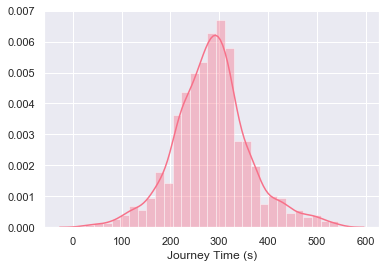

In [261]:
sns.distplot(df['Journey Time (s)'])

In [249]:
# Get rid of outliers from dataset
def detect_outlier_z_score(travel_times):
    outlier_indexes = []
    
    threshold = 3
    mean = np.mean(travel_times)
    std = np.std(travel_times)
    
    for i, t in enumerate(travel_times):
        z_score= (t - mean) / std
        
        if np.abs(z_score) > threshold:
            outlier_indexes.append(i)
    
    return outlier_indexes

outlier_indexes = detect_outlier_z_score(df['Journey Time (s)'])
print("Outlier indexes: ", outlier_indexes)
df = df.drop(outlier_indexes)

Outlier indexes:  [8, 21, 22, 33, 59, 177, 240, 243, 473, 687]


In [250]:
df.describe()

,Journey Time,Journey Time (s),Time of Day
count,820,820.000000,820.000000
mean,0 days 00:04:45.498780,285.498780,13.042683
std,0 days 00:01:17.117855,77.117855,4.302866
min,0 days 00:00:26,26.000000,5.000000
25%,0 days 00:03:59,239.000000,10.000000
50%,0 days 00:04:45,285.000000,13.000000
75%,0 days 00:05:25,325.000000,16.000000
max,0 days 00:09:04,544.000000,23.000000


[(0, 'Friday'), (1, 'Monday'), (2, 'Saturday'), (3, 'Sunday'), (4, 'Thursday'), (5, 'Tuesday'), (6, 'Wednesday')]
[(0, False), (1, True)]
Pearson Correlation Coefficient 'time of day' and 'day of 'week':  -0.015942909959803915
Pearson Correlation Coefficient 'time of day' and 'pre lockdown:  -0.03904599312556675
Pearson Correlation Coefficient 'day of week' and 'pre lockdown':  0.16561740766640717


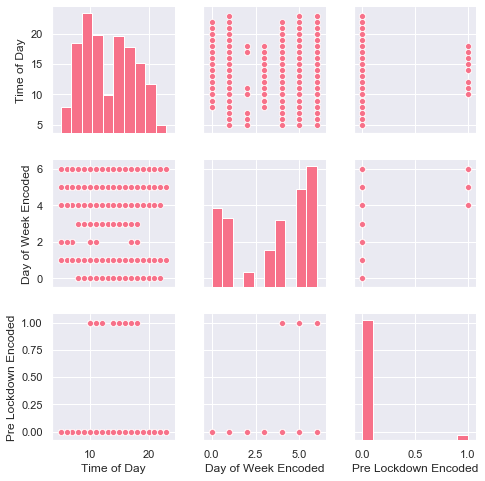

In [359]:
from scipy.stats import pearsonr

le = preprocessing.LabelEncoder()

encoded = le.fit_transform(df['Day of Week'])
df['Day of Week Encoded'] = encoded
days_of_week_label = list(le.inverse_transform([0,1,2,3,4,5,6]))
print(list(zip([0,1,2,3,4,5,6], days_of_week_label)))
encoded = le.fit_transform(df['Pre Lockdown'])
df['Pre Lockdown Encoded'] = encoded
pre_lockdown_label = list(le.inverse_transform([0, 1]))
print(list(zip([0, 1], pre_lockdown_label)))

# Calculate correlation coefficient of the 3 variables
corr_tod_dow, _ = pearsonr(df['Time of Day'], df['Day of Week Encoded'])
corr_tod_pl, _ = pearsonr(df['Time of Day'], df['Pre Lockdown Encoded'])
corr_dow_pl, _ = pearsonr(df['Day of Week Encoded'], df['Pre Lockdown Encoded'])
print("Pearson Correlation Coefficient 'time of day' and 'day of 'week': ", corr_tod_dow)
print("Pearson Correlation Coefficient 'time of day' and 'pre lockdown: ", corr_tod_pl)
print("Pearson Correlation Coefficient 'day of week' and 'pre lockdown': ", corr_dow_pl)

# Pairplot between pairs of features
sns.pairplot(df[['Time of Day', 'Day of Week Encoded', 'Pre Lockdown Encoded']], height = 2.3)

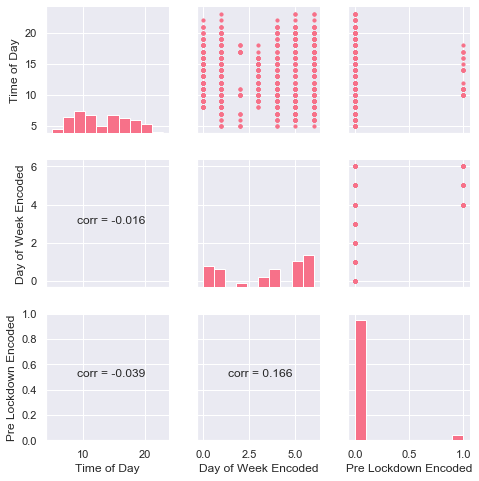

In [358]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("corr = {:.3f}".format(r),
                xy=(.25, .5), xycoords=ax.transAxes)
    
pp = sns.PairGrid(df[['Time of Day', 'Day of Week Encoded', 'Pre Lockdown Encoded']], height = 2.3)
pp.map_upper(plt.scatter, s=10)
pp.map_diag(plt.hist)
pp.map_lower(corrfunc)

#### Feature correlation

The above pairplot indicates that the features are not related to each other, i.e. they are independent of each other. This means that they can be used together in multivariate regression. This is supported by the Pearson Correlation Coefficients calculated for the three variables. The Pearson’s correlation coefficient is calculated as the covariance of the two variables divided by the product of the standard deviation of each data sample. It is the normalization of the covariance between the two variables to give an interpretable score. The coefficient returns a value between -1 and 1 that represents the limits of correlation from a full negative correlation to a full positive correlation. A value of 0 means no correlation. The value must be interpreted, where often a value below -0.5 or above 0.5 indicates a notable correlation, and values below those values suggests a less notable correlation.

#### Feature information

There is a lot more data that was collected post lockdown compared to pre lockdown (as can be seen by the bottom right graph that has a taller 0 = False bar).
There is data for post lockdown on every day of the week, but for pre lockdown there is only data for Tuesday, Thursday, Wednesday.
For post lockdown data there is data for all times of day that the bus runs, but for pre lockdown there is only data for between 1000 to approximately 1800.

From the middle graph, it can be seen that there is the least amount of data collected on a Saturday.
It can also be seen from the top middle graph that on Saturday and Sunday, there are gaps during the day where data has not been collected. For example, for both days there is no data after approximately 1800.

From the top left graph, it can be seen that the early and late times of day have the least amount of data collected.

## Linear Regression

Regression models are generally outperformed by other types of models, but they reveal which independent variable is less/more important for predicting travel times.

Try regression models with one of the variables^2, or also do separate regression models for 1) peak weekdays vs 2) nonpeak weekdays and then 3) weekends?

## Single predictor variable
### Predict journey time based on time of day

$j = b_0 + b_1t + b_2t^2$

$j = b_0 + b_1t + b_2t^2 + b_3t^3$

$j = b_0 + b_1t + b_2t^2 + b_3t^3 + b_4t^4$

where 
- $j$ is the predicted journey time
- $t$ is the time of day

This is still considered to be linear model as the coefficients/weights associated with the features are still linear. t² etc. is only a feature. However the curve that we are fitting is quadratic, cubic and quartic in nature.

It would make sense normally for time of day to have 2 peaks so that would be quartic in nature.

#### Splitting the data into training and test sets.

Need to ensure that the train and test sets are similar.

In [397]:
# Sort values by 'time of day'
df_time_of_day = df.sort_values("Time of Day")

# partition data into 4 groups sorted by time of day
group1 = df_time_of_day.iloc[:(int(df.shape[0] / 4))]
group2 = df_time_of_day.iloc[(int(df.shape[0] / 4)):(int(2 * df.shape[0] / 4))]
group3 = df_time_of_day.iloc[(int(2 * df.shape[0] / 4)):(int(3 * df.shape[0] / 4))]
group4 = df_time_of_day.iloc[(int(3 * df.shape[0] / 4)):]

# get a random sample of 80% from each group to ensure the train and test
# have similar time of days
training_time_of_day = group1.sample(frac = 0.8)
training_time_of_day = training_time_of_day.append(group2.sample(frac = 0.8))
training_time_of_day = training_time_of_day.append(group3.sample(frac = 0.8))
training_time_of_day = training_time_of_day.append(group4.sample(frac = 0.8))

# validation is all the remaining data that wasn't chosen for the training set
validation_time_of_day = df_time_of_day[~df_time_of_day.apply(tuple,1).isin(training_time_of_day.apply(tuple,1))]
print(training_time_of_day.shape, validation_time_of_day.shape)
validation_time_of_day.head()

(656, 7) (158, 7)


,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Day of Week Encoded,Pre Lockdown Encoded
145,00:03:11,191.0,Monday,5,False,1,0
164,00:02:40,160.0,Thursday,5,False,4,0
220,00:02:51,171.0,Thursday,5,False,4,0
272,00:04:34,274.0,Wednesday,6,False,6,0
277,00:03:40,220.0,Wednesday,6,False,6,0


In [398]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

def poly_regression_timeofday(degree):
    poly = PolynomialFeatures(degree = degree)
    poly.fit(training_time_of_day['Time of Day'][:, np.newaxis])

    x_train = poly.transform(training_time_of_day['Time of Day'][:, np.newaxis])
    x_test = poly.transform(validation_time_of_day['Time of Day'][:, np.newaxis])
    y_train = training_time_of_day['Journey Time (s)'][:, np.newaxis]
    y_test = validation_time_of_day['Journey Time (s)'][:, np.newaxis]

    # Fit model
    linreg = LinearRegression()
    linreg.fit(x_train, y_train)

    # Apply the model to the validation data to predict the ‘Journey Time’
    y_pred = linreg.predict(x_test)

    # Calculate measures of success
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print('Slope/Coefficients: ', linreg.coef_)
    print('Intercept: ', linreg.intercept_)
    print('The root mean squared error is: ', rmse)
    # coefficient of determination = 1 is perfect prediction
    print('The coefficient of determination is: ', r2)
    
    return y_test, y_pred, rmse, r2

y_test, y_pred_time_of_day2, rmse_time_of_day2, r2_time_of_day2 = poly_regression_timeofday(2)
y_test, y_pred_time_of_day3, rmse_time_of_day3, r2_time_of_day3 = poly_regression_timeofday(3)
y_test, y_pred_time_of_day4, rmse_time_of_day4, r2_time_of_day4 = poly_regression_timeofday(4)
y_test, y_pred_time_of_day5, rmse_time_of_day5, r2_time_of_day5 = poly_regression_timeofday(5)
y_test, y_pred_time_of_day6, rmse_time_of_day6, r2_time_of_day6 = poly_regression_timeofday(6)

Slope/Coefficients:  [[ 0.         43.81242938 -1.60847858]]
Intercept:  [17.45786122]
The root mean squared error is:  63.02606560208677
The coefficient of determination is:  0.23980856380214044
Slope/Coefficients:  [[ 0.00000000e+00  4.31876242e+01 -1.55963741e+00 -1.18855566e-03]]
Intercept:  [19.91377004]
The root mean squared error is:  63.02145345746168
The coefficient of determination is:  0.23991981886866554
Slope/Coefficients:  [[ 0.00000000e+00  3.68670319e+01 -7.84403785e-01 -4.08666999e-02
   7.21136855e-04]]
Intercept:  [37.93663348]
The root mean squared error is:  63.00106366811862
The coefficient of determination is:  0.24041156784800244
Slope/Coefficients:  [[ 0.00000000e+00 -1.91033121e+02  3.73729548e+01 -3.05954244e+00
   1.14262071e-01 -1.63412637e-03]]
Intercept:  [549.70092993]
The root mean squared error is:  63.51860261963938
The coefficient of determination is:  0.22788062763570605
Slope/Coefficients:  [[ 0.00000000e+00 -1.63404136e+03  3.47946043e+02 -3.69380

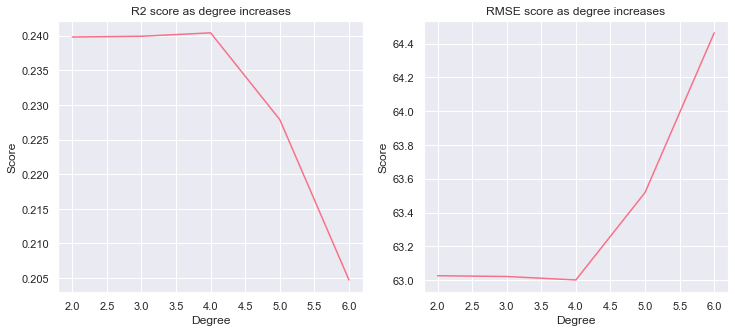

In [399]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

rmses = [rmse_time_of_day2, rmse_time_of_day3, rmse_time_of_day4, rmse_time_of_day5, rmse_time_of_day6]
r2s = [r2_time_of_day2, r2_time_of_day3, r2_time_of_day4, r2_time_of_day5, r2_time_of_day6]

ax[0].plot([2,3,4,5,6], r2s)
ax[0].set_title("R2 score as degree increases")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Score")

ax[1].plot([2,3,4,5,6], rmses)
ax[1].set_title("RMSE score as degree increases")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("Score")

plt.show()

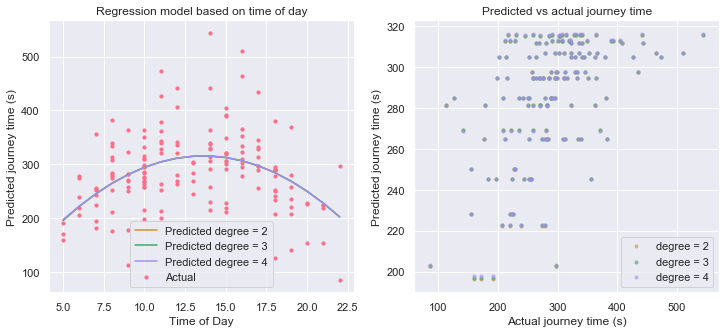

In [403]:
import operator

x = validation_time_of_day['Time of Day'][:, np.newaxis]
sort_axis = operator.itemgetter(0)
sorted_zip2 = sorted(zip(x, y_pred_time_of_day2), key=sort_axis)
sorted_zip3 = sorted(zip(x, y_pred_time_of_day3), key=sort_axis)
sorted_zip4 = sorted(zip(x, y_pred_time_of_day4), key=sort_axis)
x2, y_pred_2 = zip(*sorted_zip2)
x3, y_pred_3 = zip(*sorted_zip3)
x4, y_pred_4 = zip(*sorted_zip4)

# Plot outputs
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)
ax[0].scatter(x, y_test, label = "Actual", s = 10)
ax[0].plot(x2, y_pred_2, label = "Predicted degree = 2", color = cs[1])
ax[0].plot(x3, y_pred_3, label = "Predicted degree = 3", color = cs[3])
ax[0].plot(x4, y_pred_4, label = "Predicted degree = 4", color = cs[6])
ax[0].set_title("Regression model based on time of day")
ax[0].set_xlabel("Time of Day")
ax[0].set_ylabel("Predicted journey time (s)")
ax[0].legend()

ax[1].scatter(y_test, y_pred_time_of_day2, label = "degree = 2", color = cs[1], alpha = 0.5, s = 10)
ax[1].scatter(y_test, y_pred_time_of_day3, label = "degree = 3", color = cs[3], alpha = 0.5, s = 10)
ax[1].scatter(y_test, y_pred_time_of_day4, label = "degree = 4", color = cs[6], alpha = 0.5, s = 10)
ax[1].set_title("Predicted vs actual journey time")
ax[1].set_xlabel("Actual journey time (s)")
ax[1].set_ylabel("Predicted journey time (s)")
ax[1].legend()
plt.show()

CONCLUSIONS:

### Predict journey time based on day of week

$j = b_0 + b_1d$

$j = b_0 + b_1d + b_2d^2$

$j = b_0 + b_1d + b_2d^2 + b_3d^3$

where 
- $j$ is the predicted journey time
- $d$ is the day of week

This is still considered to be linear model as the coefficients/weights associated with the features are still linear. d² is only a feature. However the curve that we are fitting is quadratic and cubic in nature.

Day of week would maybe have 1 peak for weekdays versus weekends so should be quadratic in nature.

#### Splitting the data into training and test sets.

Need to ensure that the train and test sets are similar.

In [404]:
# partition data into 4 groups sorted by day of week
df_day_of_week = df.sort_values("Day of Week")
group1 = df_day_of_week.iloc[:(int(df.shape[0] / 4))]
group2 = df_day_of_week.iloc[(int(df.shape[0] / 4)):(int(2 * df.shape[0] / 4))]
group3 = df_day_of_week.iloc[(int(2 * df.shape[0] / 4)):(int(3 * df.shape[0] / 4))]
group4 = df_day_of_week.iloc[(int(3 * df.shape[0] / 4)):]

# get a random sample of 80% from each group to ensure the train and test
# have similar time of days
training_day_of_week = group1.sample(frac = 0.8)
training_day_of_week = training_day_of_week.append(group2.sample(frac = 0.8))
training_day_of_week = training_day_of_week.append(group3.sample(frac = 0.8))
training_day_of_week = training_day_of_week.append(group4.sample(frac = 0.8))

# validation is all the remaining data that wasn't chosen for the training set
validation_day_of_week = df[~df.apply(tuple,1).isin(training_day_of_week.apply(tuple,1))]
print(training_day_of_week.shape, validation_day_of_week.shape)
training_day_of_week.head()

(656, 7) (157, 7)


,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Day of Week Encoded,Pre Lockdown Encoded
416,00:04:30,270.0,Monday,10,False,1,0
216,00:04:01,241.0,Friday,9,False,0,0
590,00:04:51,291.0,Friday,14,False,0,0
313,00:02:51,171.0,Friday,15,False,0,0
604,00:06:46,406.0,Friday,16,False,0,0


In [405]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

def poly_regression_dayofweek(degree):
    poly = PolynomialFeatures(degree = degree)
    poly.fit(training_day_of_week['Day of Week Encoded'][:, np.newaxis])

    x_train = poly.transform(training_day_of_week['Day of Week Encoded'][:, np.newaxis])
    x_test = poly.transform(validation_day_of_week['Day of Week Encoded'][:, np.newaxis])
    y_train = training_day_of_week['Journey Time (s)'][:, np.newaxis]
    y_test = validation_day_of_week['Journey Time (s)'][:, np.newaxis]

    # Fit model
    linreg = LinearRegression()
    linreg.fit(x_train, y_train)

    # Apply the model to the validation data to predict the ‘Journey Time’
    y_pred = linreg.predict(x_test)

    # Calculate measures of success
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print('Slope/Coefficients: ', linreg.coef_)
    print('Intercept: ', linreg.intercept_)
    print('The root mean squared error is: ', rmse)
    # coefficient of determination = 1 is perfect prediction
    print('The coefficient of determination is: ', r2)
    
    return y_test, y_pred, rmse, r2

y_test, y_pred_day_of_week1, rmse_day_of_week1, r2_day_of_week1 = poly_regression_dayofweek(1)
y_test, y_pred_day_of_week2, rmse_day_of_week2, r2_day_of_week2 = poly_regression_dayofweek(2)
y_test, y_pred_day_of_week3, rmse_day_of_week3, r2_day_of_week3 = poly_regression_dayofweek(3)
y_test, y_pred_day_of_week4, rmse_day_of_week4, r2_day_of_week4 = poly_regression_dayofweek(4)
y_test, y_pred_day_of_week5, rmse_day_of_week5, r2_day_of_week5 = poly_regression_dayofweek(5)

Slope/Coefficients:  [[0.         0.75590434]]
Intercept:  [283.31666915]
The root mean squared error is:  72.30834481336552
The coefficient of determination is:  -0.0006487267037256217
Slope/Coefficients:  [[  0.         -14.61268614   2.52348558]]
Intercept:  [293.68573669]
The root mean squared error is:  72.2364866128811
The coefficient of determination is:  0.001339123755613958
Slope/Coefficients:  [[  0.         -30.55596987   9.28828327  -0.71549939]]
Intercept:  [297.79399106]
The root mean squared error is:  72.42494599389845
The coefficient of determination is:  -0.003878530871664454
Slope/Coefficients:  [[  0.         -37.47671896  15.69564975  -2.46421215   0.1453859 ]]
Intercept:  [298.42357278]
The root mean squared error is:  72.47698075169554
The coefficient of determination is:  -0.005321551382323264
Slope/Coefficients:  [[ 0.00000000e+00 -3.45624676e+01  1.11590107e+01 -2.93847355e-01
  -2.65647863e-01  2.69803199e-02]]
Intercept:  [298.38928105]
The root mean squared

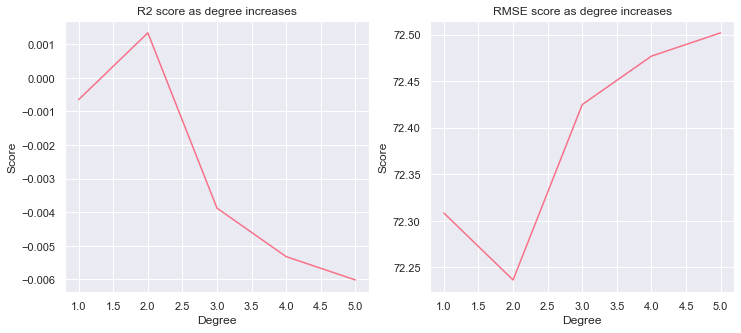

In [406]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

rmses = [rmse_day_of_week1, rmse_day_of_week2, rmse_day_of_week3, rmse_day_of_week4, rmse_day_of_week5]
r2s = [r2_day_of_week1, r2_day_of_week2, r2_day_of_week3, r2_day_of_week4, r2_day_of_week5]

ax[0].plot([1,2,3,4,5], r2s)
ax[0].set_title("R2 score as degree increases")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Score")

ax[1].plot([1,2,3,4,5], rmses)
ax[1].set_title("RMSE score as degree increases")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("Score")

plt.show()

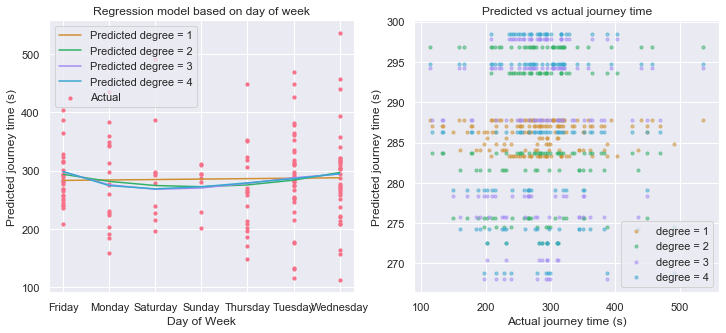

In [407]:
import operator

x = validation_day_of_week['Day of Week Encoded'][:, np.newaxis]
sort_axis = operator.itemgetter(0)
sorted_zip1 = sorted(zip(x, y_pred_day_of_week1), key=sort_axis)
sorted_zip2 = sorted(zip(x, y_pred_day_of_week2), key=sort_axis)
sorted_zip3 = sorted(zip(x, y_pred_day_of_week3), key=sort_axis)
sorted_zip4 = sorted(zip(x, y_pred_day_of_week4), key=sort_axis)
x1, y_pred_1 = zip(*sorted_zip1)
x2, y_pred_2 = zip(*sorted_zip2)
x3, y_pred_3 = zip(*sorted_zip3)
x4, y_pred_4 = zip(*sorted_zip4)

# Plot outputs
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)
ax[0].scatter(x, y_test, label = "Actual", s = 10)
ax[0].plot(x1, y_pred_1, label = "Predicted degree = 1", color = cs[1])
ax[0].plot(x2, y_pred_2, label = "Predicted degree = 2", color = cs[3])
ax[0].plot(x3, y_pred_3, label = "Predicted degree = 3", color = cs[6])
ax[0].plot(x4, y_pred_4, label = "Predicted degree = 4", color = cs[5])
ax[0].set_title("Regression model based on day of week")
ax[0].set_xlabel("Day of Week")
ax[0].set_ylabel("Predicted journey time (s)")
ax[0].set_xticks([0,1,2,3,4,5,6])
ax[0].set_xticklabels(days_of_week_label)
ax[0].legend()

ax[1].scatter(y_test, y_pred_day_of_week1, label = "degree = 1", color = cs[1], alpha = 0.5, s = 10)
ax[1].scatter(y_test, y_pred_day_of_week2, label = "degree = 2", color = cs[3], alpha = 0.5, s = 10)
ax[1].scatter(y_test, y_pred_day_of_week3, label = "degree = 3", color = cs[6], alpha = 0.5, s = 10)
ax[1].scatter(y_test, y_pred_day_of_week4, label = "degree = 4", color = cs[5], alpha = 0.5, s = 10)
ax[1].set_title("Predicted vs actual journey time")
ax[1].set_xlabel("Actual journey time (s)")
ax[1].set_ylabel("Predicted journey time (s)")
ax[1].legend()
plt.show()

CONCLUSIONS:
The higher the R2 score the better (1 = perfect), so the above graph indicates that degree = 3 is optimal model.

## Multiple predictor variables == Multiple Linear Regression

### Time of Day, Day of Week

$j = b_0 + b_1d + b_2t$

$j = b_0 + b_1d^2 + b_2dt + b_3t^2$

$j = b_0 + b_1d^3 + b_2d^2t + b_3dt^2 + b_4t^3$

where 
- $j$ is the predicted journey time
- $d$ is the day of week
- $t$ is the time of day

#### Splitting the data into training and test sets.

Need to ensure that the train and test sets are similar.

In [424]:
# partition data into 4 groups
df_mult = df.sort_values(["Time of Day", "Day of Week"])
group1 = df_mult.iloc[:(int(df.shape[0] / 4))]
group2 = df_mult.iloc[(int(df.shape[0] / 4)):(int(2 * df.shape[0] / 4))]
group3 = df_mult.iloc[(int(2 * df.shape[0] / 4)):(int(3 * df.shape[0] / 4))]
group4 = df_mult.iloc[(int(3 * df.shape[0] / 4)):]

# get a random sample of 80% from each group to ensure the train and test
# have similar time of days
training_mult = group1.sample(frac = 0.8)
training_mult = training_mult.append(group2.sample(frac = 0.8))
training_mult = training_mult.append(group3.sample(frac = 0.8))
training_mult = training_mult.append(group4.sample(frac = 0.8))

# validation is all the remaining data that wasn't chosen for the training set
validation_mult = df[~df.apply(tuple,1).isin(training_mult.apply(tuple,1))]
print(training_mult.shape, validation_mult.shape)
training_mult.head()

(656, 7) (157, 7)


,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Day of Week Encoded,Pre Lockdown Encoded
165,00:04:12,252.0,Sunday,9,False,3,0
277,00:03:40,220.0,Wednesday,6,False,6,0
156,00:03:50,230.0,Tuesday,7,False,5,0
23,00:03:50,230.0,Saturday,7,False,2,0
556,00:05:39,339.0,Friday,10,False,0,0


In [425]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

def poly_regression_mult(degree):
    poly = PolynomialFeatures(degree = degree)
    poly.fit(training_mult[['Day of Week Encoded', 'Time of Day']])

    x_train = poly.transform(training_mult[['Day of Week Encoded', 'Time of Day']])
    x_test = poly.transform(validation_mult[['Day of Week Encoded', 'Time of Day']])
    y_train = training_mult['Journey Time (s)'][:, np.newaxis]
    y_test = validation_mult['Journey Time (s)'][:, np.newaxis]
    
    # Scale the data
    scaler = preprocessing.StandardScaler()
    scaler = scaler.fit(x_train)
    x_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Fit model
    linreg = LinearRegression()
    linreg.fit(x_scaled, y_train)

    # Apply the model to the validation data to predict the ‘Journey Time’
    y_pred = linreg.predict(x_test_scaled)

    # Calculate measures of success
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print('Slope/Coefficients: ', linreg.coef_)
    print('Intercept: ', linreg.intercept_)
    print('The root mean squared error is: ', rmse)
    # coefficient of determination = 1 is perfect prediction
    print('The coefficient of determination is: ', r2)
    
    return y_test, y_pred, rmse, r2

y_pred_mults = []
rmse_mults = []
r2_mults = []
y_test = []

for i in range(1, 15):
    y_test, y_pred_mult, rmse_mult, r2_mult = poly_regression_mult(i)
    y_pred_mults.append(y_pred_mult)
    rmse_mults.append(rmse_mult)
    r2_mults.append(r2_mult)

Slope/Coefficients:  [[0.         1.92990681 0.60113154]]
Intercept:  [286.67835366]
The root mean squared error is:  74.0660722763903
The coefficient of determination is:  -0.006709117890146832
Slope/Coefficients:  [[   0.          -12.09137342  205.85891649   26.30307092   -8.5843762
  -204.32777035]]
Intercept:  [286.67835366]
The root mean squared error is:  68.46211851445231
The coefficient of determination is:  0.13986614726053082
Slope/Coefficients:  [[   0.         -130.3664484   163.57619305  183.53351241  137.72465345
  -192.20538504 -105.80195597   11.07012004 -109.0091937    30.47154552]]
Intercept:  [286.67835366]
The root mean squared error is:  69.89285298101757
The coefficient of determination is:  0.10354001318516293
Slope/Coefficients:  [[    0.          -104.50274009  -205.6096827   -308.45167804
    271.87509309  1084.36200955   948.15995922  -301.39705358
    -81.46066038 -1484.13343147  -564.44380584    71.23976082
    139.95694794   -87.53740562   607.00157348]]


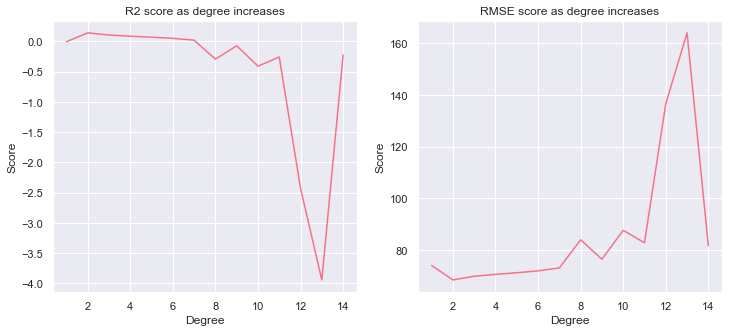

In [426]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].plot(range(1,15), r2_mults)
ax[0].set_title("R2 score as degree increases")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Score")

ax[1].plot(range(1,15), rmse_mults)
ax[1].set_title("RMSE score as degree increases")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("Score")

plt.show()

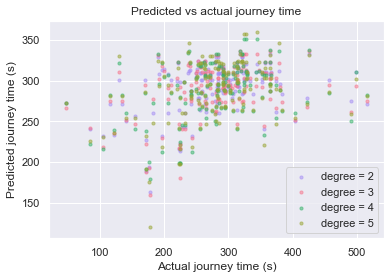

In [428]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_mults[1], label = "degree = 2", color = cs[6], alpha = 0.5, s = 10)
ax.scatter(y_test, y_pred_mults[2], label = "degree = 3", color = cs[0], alpha = 0.5, s = 10)
ax.scatter(y_test, y_pred_mults[3], label = "degree = 4", color = cs[3], alpha = 0.5, s = 10)
ax.scatter(y_test, y_pred_mults[4], label = "degree = 5", color = cs[2], alpha = 0.5, s = 10)
ax.set_title("Predicted vs actual journey time")
ax.set_xlabel("Actual journey time (s)")
ax.set_ylabel("Predicted journey time (s)")
ax.legend()
plt.show()

### Time of Day, Day of Week, Pre/Post Lockdown

#### Splitting the data into training and test sets.

Need to ensure that the train and test sets are similar.

In [429]:
# partition data into 4 groups
df_mult = df.sort_values(["Pre Lockdown", "Time of Day", "Day of Week"])
group1 = df_mult.iloc[:(int(df.shape[0] / 4))]
group2 = df_mult.iloc[(int(df.shape[0] / 4)):(int(2 * df.shape[0] / 4))]
group3 = df_mult.iloc[(int(2 * df.shape[0] / 4)):(int(3 * df.shape[0] / 4))]
group4 = df_mult.iloc[(int(3 * df.shape[0] / 4)):]

# get a random sample of 80% from each group to ensure the train and test
# have similar time of days
training_mult = group1.sample(frac = 0.8)
training_mult = training_mult.append(group2.sample(frac = 0.8))
training_mult = training_mult.append(group3.sample(frac = 0.8))
training_mult = training_mult.append(group4.sample(frac = 0.8))

# validation is all the remaining data that wasn't chosen for the training set
validation_mult = df[~df.apply(tuple,1).isin(training_mult.apply(tuple,1))]
print(training_mult.shape, validation_mult.shape)
training_mult.head()

(656, 7) (159, 7)


,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Day of Week Encoded,Pre Lockdown Encoded
345,00:04:21,261.0,Sunday,9,False,3,0
281,00:04:16,256.0,Wednesday,7,False,6,0
555,00:05:19,319.0,Friday,10,False,0,0
342,00:04:00,240.0,Sunday,9,False,3,0
499,00:02:52,172.0,Tuesday,6,False,5,0


In [430]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

def poly_regression_mult(degree):
    poly = PolynomialFeatures(degree = degree)
    poly.fit(training_mult[['Day of Week Encoded', 'Time of Day', 'Pre Lockdown Encoded']])

    x_train = poly.transform(training_mult[['Day of Week Encoded', 'Time of Day', 'Pre Lockdown Encoded']])
    x_test = poly.transform(validation_mult[['Day of Week Encoded', 'Time of Day', 'Pre Lockdown Encoded']])
    y_train = training_mult['Journey Time (s)'][:, np.newaxis]
    y_test = validation_mult['Journey Time (s)'][:, np.newaxis]
    
    # Scale the data
    scaler = preprocessing.StandardScaler()
    scaler = scaler.fit(x_train)
    x_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Fit model
    linreg = LinearRegression()
    linreg.fit(x_scaled, y_train)

    # Apply the model to the validation data to predict the ‘Journey Time’
    y_pred = linreg.predict(x_test_scaled)

    # Calculate measures of success
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print('Slope/Coefficients: ', linreg.coef_)
    print('Intercept: ', linreg.intercept_)
    print('The root mean squared error is: ', rmse)
    # coefficient of determination = 1 is perfect prediction
    print('The coefficient of determination is: ', r2)
    
    return y_test, y_pred, rmse, r2

y_pred_mults = []
rmse_mults = []
r2_mults = []
y_test = []

for i in range(1, 15):
    y_test, y_pred_mult, rmse_mult, r2_mult = poly_regression_mult(i)
    y_pred_mults.append(y_pred_mult)
    rmse_mults.append(rmse_mult)
    r2_mults.append(r2_mult)

Slope/Coefficients:  [[ 0.         -1.17799891  2.14193555 22.79473083]]
Intercept:  [285.46036585]
The root mean squared error is:  78.81744278231594
The coefficient of determination is:  0.02150902467452598
Slope/Coefficients:  [[   0.            3.93221728  183.68297158    7.83235045   19.15639051
   -22.98914774   38.04948246 -173.08905835  -35.64111748    7.83235045]]
Intercept:  [285.46036585]
The root mean squared error is:  72.11690904433712
The coefficient of determination is:  0.1808067727836694
Slope/Coefficients:  [[   0.          -51.01352322   85.20450174 -133.0169669    62.53923793
    63.93319785  506.22814019   -2.28411139  -55.93839146 -133.0169669
   -15.21315348  -20.28046579 -585.31838654  -46.02371581   97.10436919
   506.22814019  -76.27408398   -7.11089193  -55.93839146 -133.0169669 ]]
Intercept:  [285.46036585]
The root mean squared error is:  72.3637405920571
The coefficient of determination is:  0.17518953903685597
Slope/Coefficients:  [[-1.66541623e+14  5.17

Slope/Coefficients:  [[-2.59783661e+14  2.05747394e+11 -7.03122915e+05  3.63531175e+12
  -2.86814270e+12 -7.22050865e+10  3.76227659e+12  6.57981539e+06
   3.89258186e+13 -5.34809868e+13  1.34914246e+13  9.73069120e+11
   1.02958112e+13  3.06057768e+09 -8.15538750e+13 -5.11928355e+13
  -3.03160080e+07  3.00969313e+13  1.85414945e+13 -2.34694746e+13
  -2.74360430e+13 -4.44819986e+12 -6.23699030e+13 -2.91676229e+10
  -5.98960144e+12  6.36774733e+10 -2.92917278e+10 -6.25257649e+13
   2.20901203e+13  4.66855984e+13  8.84428551e+07 -1.42181910e+13
   3.15645933e+13  1.78985149e+13 -2.32830875e+13  2.31652363e+13
   8.10102772e+12  2.09648702e+13  2.58167807e+10  2.67357240e+13
  -1.67510964e+13  4.07722828e+11  2.49129020e+13 -6.57569605e+12
   3.38020319e+11 -6.31355131e+07  2.47341165e+12 -4.12621486e+11
   2.19545493e+13  4.67528680e+13 -1.76413996e+08  4.59275978e+13
  -5.94439976e+13  3.16618306e+13  1.21449617e+13  3.31682465e+12
  -7.99881295e+12 -2.34063251e+12  1.16019275e+13  5.17

Slope/Coefficients:  [[ 2.29774276e+14 -6.64488945e+11 -8.59800731e+06 -1.00615577e+14
   8.95135252e+12  1.22242339e+11 -6.02166199e+13  5.66501609e+07
   1.27171631e+14 -2.19020687e+14 -3.92713186e+13 -1.58002486e+12
  -1.80920771e+13  2.70063428e+10  1.29913786e+14  2.01711629e+14
  -4.67106686e+07 -7.12228159e+12 -4.14969305e+12  1.45119306e+13
   6.74149367e+13  6.81773906e+12 -4.98909298e+12 -3.80845269e+11
  -8.39436681e+12  1.11991580e+12  5.70335361e+10  4.54349005e+12
  -1.24050325e+13  2.86719844e+12 -9.63934319e+08 -5.98846606e+12
  -5.61414142e+12 -2.35386831e+12  1.71673354e+13 -2.64627908e+13
  -1.18295151e+13  6.00103660e+12  1.89445421e+12 -3.90610114e+12
  -4.44745119e+12 -5.23570169e+11 -3.02711216e+12 -6.68511776e+12
   1.17664133e+12 -1.10241467e+11  1.76302625e+12  5.69716889e+12
  -1.23678949e+13  2.87957297e+12  5.72648413e+09 -7.09181137e+11
  -6.96063384e+12 -6.48507348e+12 -2.30580331e+12  1.70969684e+13
  -2.83210706e+13  5.61215906e+12 -4.43679638e+12 -4.42

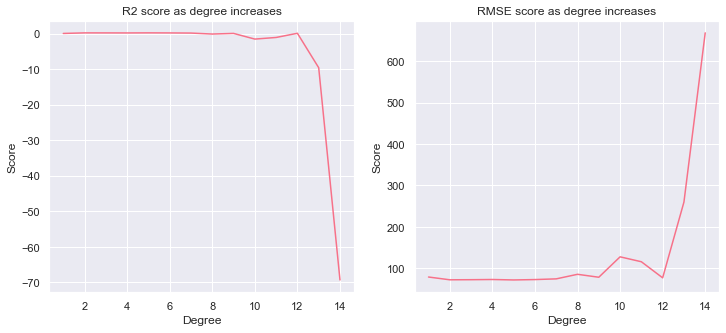

In [431]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].plot(range(1,15), r2_mults)
ax[0].set_title("R2 score as degree increases")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Score")

ax[1].plot(range(1,15), rmse_mults)
ax[1].set_title("RMSE score as degree increases")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("Score")

plt.show()

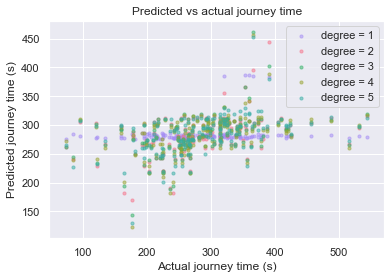

In [432]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_mults[0], label = "degree = 1", color = cs[6], alpha = 0.5, s = 10)
ax.scatter(y_test, y_pred_mults[1], label = "degree = 2", color = cs[0], alpha = 0.5, s = 10)
ax.scatter(y_test, y_pred_mults[2], label = "degree = 3", color = cs[3], alpha = 0.5, s = 10)
ax.scatter(y_test, y_pred_mults[3], label = "degree = 4", color = cs[2], alpha = 0.5, s = 10)
ax.scatter(y_test, y_pred_mults[4], label = "degree = 5", color = cs[4], alpha = 0.5, s = 10)
ax.set_title("Predicted vs actual journey time")
ax.set_xlabel("Actual journey time (s)")
ax.set_ylabel("Predicted journey time (s)")
ax.legend()
plt.show()

## Piecewise linear regression

Split the data into chunks and perform the linear regression separately on the different chunks.

Continuous piecewise linear regression -> can stick it together after